# Exercise 2 - Exploring summary stats


We will use summary stats from 

Mahajan A, et al. (2018). Fine-mapping type 2 diabetes loci to single-variant 
resolution using high-density imputation and islet-specific epigenome maps. Nature Genetics http://dx.doi.org/10.1038/s41588-018-0241-6.

with summary stats available from 
https://diagram-consortium.org/downloads.html





First let's copy the summary stats to your folder:


In [ ]:
#copy summary stats to your folder
cp /course/novo23/gwas/sumstats/Mahajan.NatGenet2018b.UKBB.HRC.T2D.European.txt .

#see which files are now in your folder
ls

Now count the number of lines in the file:

In [3]:
#count the number of lines
wc -l Mahajan.NatGenet2018b.UKBB.HRC.T2D.European.txt 

13583104 Mahajan.NatGenet2018b.UKBB.HRC.T2D.European.txt


Let's first have a look at the first 10 lines of the file:

In [4]:
head Mahajan.NatGenet2018b.UKBB.HRC.T2D.European.txt | column -t

SNP       Chr  Pos     EA  NEA  EAF    Beta    SE     Pvalue   N
1:64904   1    64904   T   G    0.999  -0.58   0.32   6.8E-02  442817
1:64908   1    64908   A   G    0.999  -0.22   0.27   4.2E-01  442817
1:79033   1    79033   A   G    0.001  0.09    0.24   7.0E-01  442817
1:533198  1    533198  C   T    0.999  -0.069  0.29   8.1E-01  442817
1:544584  1    544584  C   T    0.998  0.2     0.17   2.4E-01  442817
1:546697  1    546697  A   G    0.09   -0.019  0.025  4.6E-01  442817
1:564397  1    564397  T   C    0.999  -0.87   0.29   2.7E-03  442817
1:565111  1    565111  T   C    0.998  -0.15   0.2    4.6E-01  442817
1:565205  1    565205  G   A    0.999  -0.39   0.29   1.8E-01  442817


The different columns correspond to: 
- SNP ID
- Chromosome
- Position
- Effect Allele
- Non Effect Allele
- Effect allele frequency
- Beta (effect Size)
- Standard error of effect size
- Pvalue
- Number of individuals

How many variants are in your file?





To reduce the computational burden in this exercise, let's only look at the common variants with MAF>1% and remove some of the colums we don't need: 

In [5]:
##cut columns 2,3,6,7,9 and remove site with low minor allele frequency
cut -f 2,3,6,7,9 Mahajan.NatGenet2018b.UKBB.HRC.T2D.European.txt | \
awk 'NR==1 || ($3<0.99 && $3>0.01)' > Mahajan.maf1.txt

head Mahajan.maf1.txt

echo "number of lines"
wc -l Mahajan.maf1.txt


Chr	Pos	EAF	Beta	Pvalue
1	546697	0.09	-0.019	4.6E-01
1	693731	0.9	0.024	1.6E-01
1	705882	0.9	0.0077	7.6E-01
1	706368	0.5	0.0047	7.1E-01
1	722670	0.9	-0.0086	6.8E-01
1	723891	0.04	-0.012	6.6E-01
1	729679	0.2	-0.018	2.1E-01
1	730087	0.9	0.013	5.8E-01
1	731718	0.9	0.021	1.8E-01
number of lines
5504042 Mahajan.maf1.txt


Now make a manhattan plot in R:

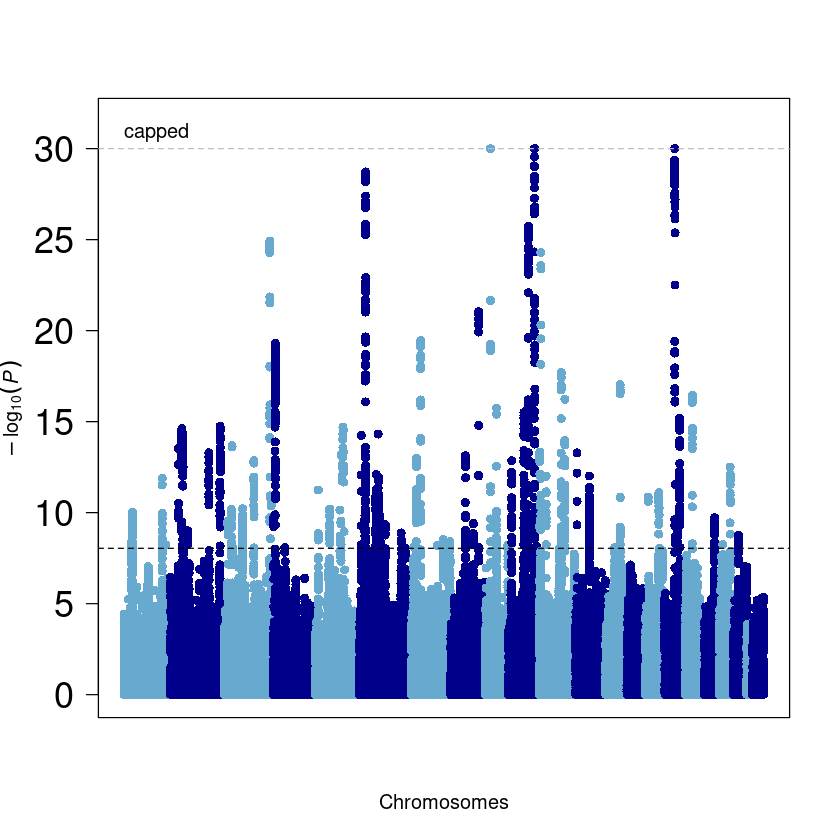

In [6]:
# read in the data 
d<-data.table::fread("~/Mahajan.maf1.txt")

# source R function for plotting
source("/course/novo23/scripts/newPlotPlink.R")

# make manhattan plot
manPlot(d$Pvalue,d$Chr,cap=1e-30)

*If the plot does not show up, then rerun above cell*
 - How does the Manhattan plot look? 
 - How many association signals are there?

Try to change the cap option above in order to better see the number of peaks. e.g. cap=1e-30. 

And then try to make a QQ plot:

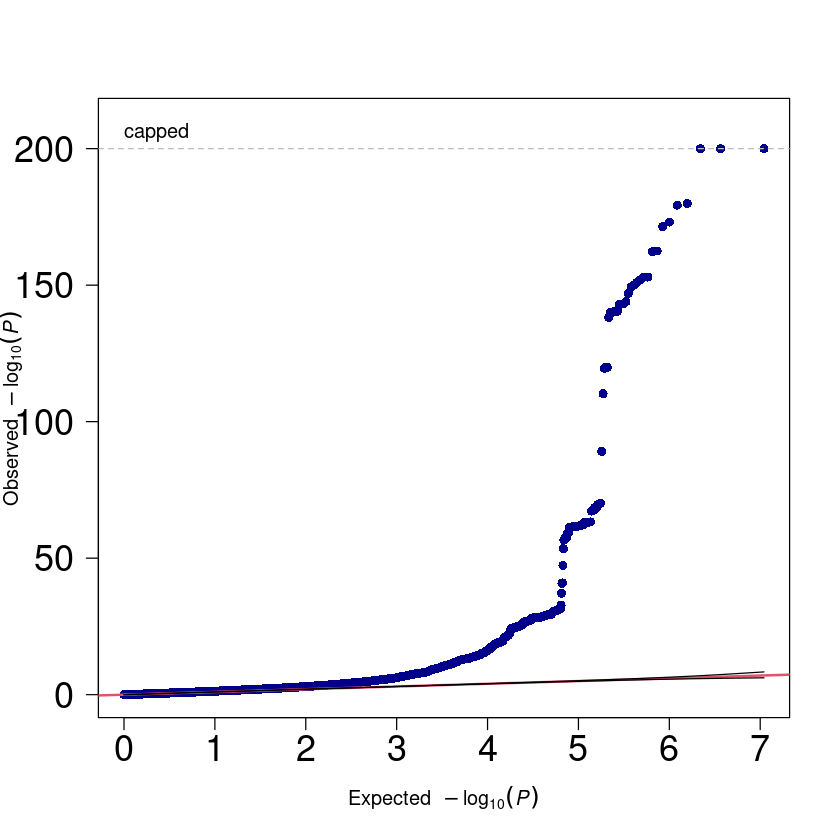

In [7]:
source("/course/novo23/scripts/newPlotPlink.R")

qqPlot(d$Pvalue,cap=1e-200) # <- try to change the cap

- How does the QQ plot look? Anything we should be worried about?

Try to change the cap option above in order to better see the shape of the QQ plot. e.g. cap=1e-30. 

# Highly polygenetic

As briefly mentioned in the lecture that are special issues one should consider if you have a very large sample size and if a trait is highly polygenic. In this case many of the SNPs in the genome will be in LD with a causal variant which will cause the QQ plot to look inflated. 

There is a nice method to evaluate this - called LD score regression - which we will be briefly mentioned. The output for this analysis 

**Total Liability scale h2: 0.0467 (0.0028)**

**Lambda GC: 1.3101**

**Mean Chi$^2$: 1.4606**

**Intercept: 1.0649 (0.0116)**

**Ratio: 0.1409 (0.0252)**

Indicates that most of the inflation observed in the qq plot is due to the trait being highly polygenetic. We will get back to these numbers later :-)

# Highest peak
Let's have a look at the highest peak. First let's have a look at the top SNP:

In [8]:
w <- which.min(d$Pvalue)
d[w,]

Chr,Pos,EAF,Beta,Pvalue
<int>,<int>,<dbl>,<dbl>,<dbl>
10,114758349,0.7,-0.34,6.1e-203


The effect estimate (Beta) is the regression coefficient from the logistic regression, which is the logarithm of the odds ratio. Also, the measured effect allele is the common allele. We can convert to odds ratio using the exponential function:

In [9]:
beta <- -0.34

## convert to odds ratio
OR <- exp(beta)
cat("OR=",OR)

OR= 0.7117703

- Try to estimate the odds ratio for the minor allele (change the sign of the effect size).

### Plot region

Let's visualize the region and see if we can identify the gene and causal variant:

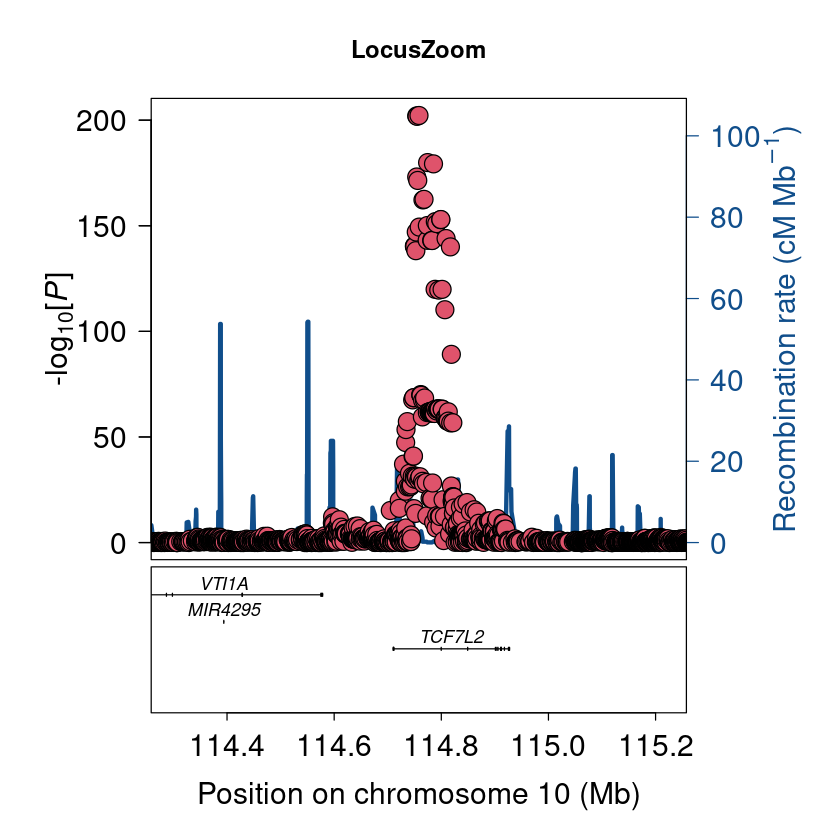

In [10]:
#select sites to plot, 0.5Mb on either side of SNP
pos <- 114758349
chr <- 10
win <- 5e5 # <- change this to zoom in

region <- subset(d,Chr==chr & Pos > pos-win &  Pos < pos+win)

#plot
locusZoomNoLD(region$Pvalue,chr=chr,pos=region$Pos,main="LocusZoom")

- Based on the plot what is the candidate gene?
- Can we be sure this is the causal gene?
- How many candidates are there for the causal allele (you can zoom in by changing the window size in the R code above and then rerunning the code)?

## overview of signals
Lets try to summaries different association signals. For simplicity lets assume that each peak represents only a single causal SNP. The below code will define a peak as being 1Mb and it will print the number of peaks

In [11]:
## choose width of association peaks
win <- 1e6
g<-as.data.frame(subset(d,Pvalue<5e-8))


leadSNPs <- c()
for(i in 1:100){
    #find top SNP
    w <- which.min(g$Pvalue)
    leadSNPs <- rbind(leadSNPs,g[w,])
    #remove region around top SNP
    g <- subset(g,Chr!=g[w,"Chr"] | Pos < g[w,"Pos"] -win |  Pos > g[w,"Pos"]+win)
}

cat("number of peaks")
nrow(leadSNPs)


number of peaks

[1] 71

Print table of peaks on chr 3 

In [12]:
subset(leadSNPs,Chr==3)

,Chr,Pos,EAF,Beta,Pvalue
,<int>,<int>,<dbl>,<dbl>,<dbl>
1037,3,185510613,0.7,-0.120,1.2e-25
874,3,23454790,0.8,0.097,2.1e-14
990,3,123069058,0.8,0.088,1.4e-13
1087,3,187741842,0.4,-0.070,2.8e-11
963,3,63982670,0.9,0.099,6.0e-11
765,3,12329783,0.9,0.100,2.9e-10
1083,3,186665645,0.5,-0.062,2.7e-09
938,3,49860854,0.3,-0.060,3.7e-08


 one of the first variants known to be associated with type 2 diabetes is found on this chromosome in a gene located around position 12.3Mb. You can see the region with the following code

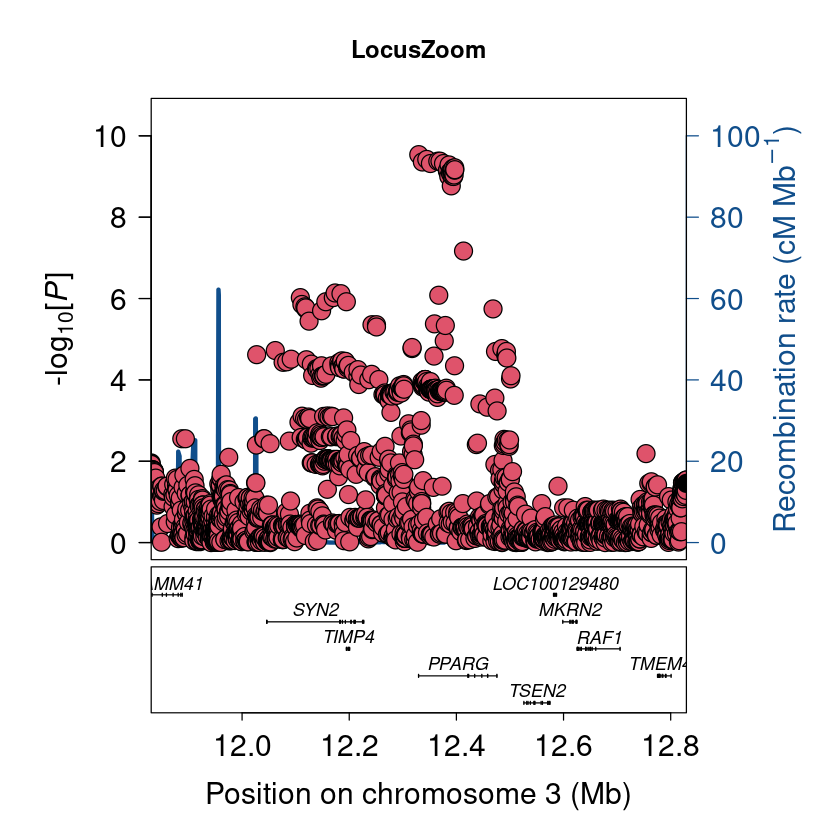

In [13]:
#select sites to plot, 0.5Mb on either side of SNP

pos <- 12329783
chr <- 3
win <- 5e5
region <- subset(d,Chr==chr & Pos > pos-win &  Pos < pos+win)

#plot
locusZoomNoLD(region$Pvalue,chr=chr,pos=region$Pos,main="LocusZoom")

We will futher explore this association signal using online resources.

However, fell free to explore other top signals and identify the gene by changing the above code (for example the top peak on chromosome 16). E.g. instead of chromosome 3 get the table of peaks for chromosome 16 and use its position to make a locuszoom plot.